In [1]:
import pandas as pd 
import janitor

def get_data():
    URL_CSV="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    df = pd.read_csv(URL_CSV)
    df['Country/Region'] = df['Country/Region'].replace({'US':'United States of America'})
    return df
df = get_data()
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,39297,39341,39422,39486,39548,39616,39693,39703,39799,39870
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,14117,14266,14410,14568,14730,14899,15066,15231,15399,15570
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,51995,52136,52270,52399,52520,52658,52804,52940,53072,53325
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,2110,2110,2370,2370,2568,2568,2696,2696,2696,2995
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,5370,5402,5530,5725,5725,5958,6031,6246,6366,6488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,41078,41498,41957,42432,42840,43256,43664,43945,44299,44684
263,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
264,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2041,2041,2041,2047,2049,2050,2051,2051,2052,2052
265,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,14974,15052,15089,15170,15224,15301,15339,15415,15458,15549


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2,2020-01-24,-3.221971e+03,0.000000e+00,1.111902e+05,-3.221971e+03,-3.221971e+03,18422.956042,18422.956042,18422.956042,18422.956042,18422.956042,18422.956042,0.0,0.0,0.0,1.520099e+04
3,2020-01-25,-4.625748e+02,0.000000e+00,1.181731e+05,-4.625748e+02,-4.625748e+02,20746.997035,20746.997035,20746.997035,20746.997035,20746.997035,20746.997035,0.0,0.0,0.0,2.028442e+04
4,2020-01-26,2.296821e+03,0.000000e+00,9.732512e+04,2.296821e+03,2.296821e+03,2479.519045,2479.519045,2479.519045,2479.519045,2479.519045,2479.519045,0.0,0.0,0.0,4.776340e+03
8,2020-01-30,1.333440e+04,0.000000e+00,1.170653e+05,1.333440e+04,1.333440e+04,2980.172664,2980.172664,2980.172664,2980.172664,2980.172664,2980.172664,0.0,0.0,0.0,1.631458e+04
9,2020-01-31,1.609346e+04,0.000000e+00,1.341446e+05,1.609346e+04,1.609346e+04,18422.956042,18422.956042,18422.956042,18422.956042,18422.956042,18422.956042,0.0,0.0,0.0,3.451642e+04
10,2020-02-01,1.885252e+04,0.000000e+00,1.386213e+05,1.885252e+04,1.885252e+04,20746.997035,20746.997035,20746.997035,20746.997035,20746.997035,20746.997035,0.0,0.0,0.0,3.959952e+04
11,2020-02-02,2.161158e+04,0.000000e+00,1.191919e+05,2.161158e+04,2.161158e+04,2479.519045,2479.519045,2479.519045,2479.519045,2479.519045,2479.519045,0.0,0.0,0.0,2.409109e+04
12,2020-02-03,2.437063e+04,0.000000e+00,1.185168e+05,2.437063e+04,2.437063e+04,-9036.467832,-9036.467832,-9036.467832,-9036.467832,-9036.467832,-9036.467832,0.0,0.0,0.0,1.533417e+04
13,2020-02-04,2.712969e+04,0.000000e+00,9.956577e+04,2.712969e+04,2.712969e+04,-22396.913368,-22396.913368,-22396.913368,-22396.913368,-22396.913368,-22396.913368,0.0,0.0,0.0,4.732777e+03
14,2020-02-05,2.988875e+04,0.000000e+00,1.099974e+05,2.988875e+04,2.988875e+04,-13196.263584,-13196.263584,-13196.263584,-13196.263584,-13196.263584,-13196.263584,0.0,0.0,0.0,1.669248e+04


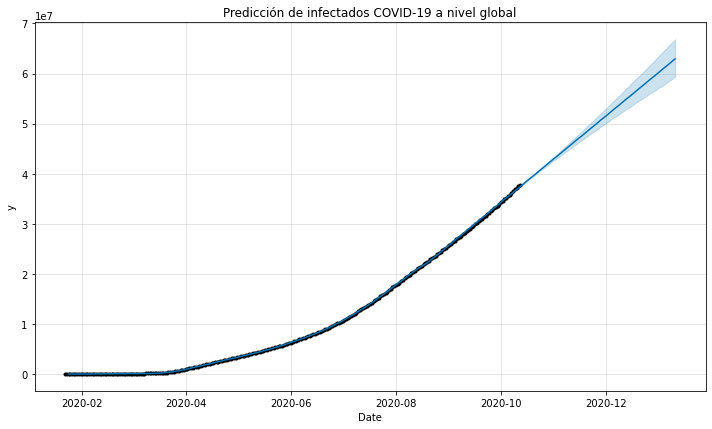

In [2]:
import janitor
import pandas as pd
import pandas_flavor as pf
import fbprophet
from matplotlib import pyplot as plt    
from IPython.display import display, HTML



LISTA_COLUMNAS_A_BORRAR = ['Province/State', 'Country/Region', 'Lat', 'Long']



df = get_data()
df = df.remove_columns(LISTA_COLUMNAS_A_BORRAR)
df
df = pd.DataFrame( df.sum())
df.columns=['y']
df.index = pd.to_datetime(df.index)  
df['ds'] = df.index
df = df.reset_index()


df = df.remove_columns(['index'])


df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
df_prophet.fit(df)

df_forecast = df_prophet.make_future_dataframe(periods=90, freq='D')
# Make predictions
df_forecast = df_prophet.predict(df_forecast)
df_forecast

df_forecast = df_forecast[df_forecast["yhat"] >= 0]
df_forecast.loc[df_forecast.yhat_lower < 0, 'yhat_lower'] = 0


df_prophet.plot(df_forecast, xlabel = 'Date' )
plt.title('Predicción de infectados COVID-19 a nivel global'   )

display(HTML(pd.DataFrame(df_forecast).to_html()))


In [3]:
df = get_data()
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,39297,39341,39422,39486,39548,39616,39693,39703,39799,39870
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,14117,14266,14410,14568,14730,14899,15066,15231,15399,15570
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,51995,52136,52270,52399,52520,52658,52804,52940,53072,53325
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,2110,2110,2370,2370,2568,2568,2696,2696,2696,2995
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,5370,5402,5530,5725,5725,5958,6031,6246,6366,6488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,41078,41498,41957,42432,42840,43256,43664,43945,44299,44684
263,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
264,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2041,2041,2041,2047,2049,2050,2051,2051,2052,2052
265,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,14974,15052,15089,15170,15224,15301,15339,15415,15458,15549


In [4]:

import janitor
import datetime
import numpy as np

def pipeline_populations():
    """ Cogemos un dataframe de poblaciones"""

    URL="https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv"
    THIS_YEAR = datetime.datetime.now().year

    return (
        pd.read_csv(URL)
        .filter_on( f""" Time  ==  {THIS_YEAR} & Variant == "Medium" """ ) 
        .select_columns(['Location','PopTotal'])
        .join_apply(lambda x: x['PopTotal'] * 1000 , new_column_name="PopMillions" )
        .remove_columns(['PopTotal'])
        .rename_column('PopMillions' , 'PopTotal')
        .transform_column('PopTotal',np.int64)
        .rename_column('Location' , 'Country/Region')
    )


populations = pipeline_populations()
populations

,Country/Region,PopTotal
70,Afghanistan,38928341
954,Africa,1340598113
1838,African Group,1338826591
1989,African Union,1339423920
2140,African Union: Central Africa,158619638
...,...,...
277315,World,7794798728
278199,World Bank Regional Groups (developing only),6528762227
278350,Yemen,29825967
279234,Zambia,18383956


In [5]:
df = get_data()
df_country = pd.DataFrame()
df_country['Country/Region'] = df['Country/Region']
df_country['infected last_day'] = df.iloc[:,-1] - df.iloc[:,-2]
df_country.set_index('Country/Region')
df_country

,Country/Region,infected last_day
0,Afghanistan,71
1,Albania,171
2,Algeria,253
3,Andorra,299
4,Angola,122
...,...,...
262,West Bank and Gaza,385
263,Western Sahara,0
264,Yemen,0
265,Zambia,91


In [6]:
df_country_enrich = pd.merge(df_country, populations, on="Country/Region")
df_country_enrich['Infected/Million'] =  1000000 * df_country_enrich['infected last_day'] / df_country_enrich['PopTotal'] 
df_country = df_country_enrich

In [7]:
df_country.sort_values(by='Infected/Million', ascending=False).head(10)

,Country/Region,infected last_day,PopTotal,Infected/Million
132,Holy See,7,809,8652.657602
3,Andorra,299,77265,3869.798745
119,France,42956,65273512,658.092367
213,Spain,27856,46754782,595.789325
218,Switzerland,4068,8654618,470.038077
140,Israel,3538,8655541,408.755501
92,Czechia,4311,10708982,402.559272
177,Netherlands,6845,17134873,399.477720
88,Costa Rica,1784,5094114,350.208103
23,Belgium,3622,11589616,312.521140


In [8]:
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates


def pintar_grafico(df, array_naciones_pintar ,title):
    df = df.T
    df = df.iloc[1:]
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    df = df.iloc[2:]
    df.index = pd.to_datetime(df.index)
    df = df[array_naciones_pintar]
    df = df.iloc[:, : 9]
    chart_df = df

    pd.plotting.register_matplotlib_converters()
    chart_df.plot(legend=True,figsize=(13.5,9))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=45)

    ax = plt.gca()

    ax.set_title(title)
    ax.set_ylim(ymin=0)

    plt.show()

    #df.tail(30).style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia', )
    return plt 



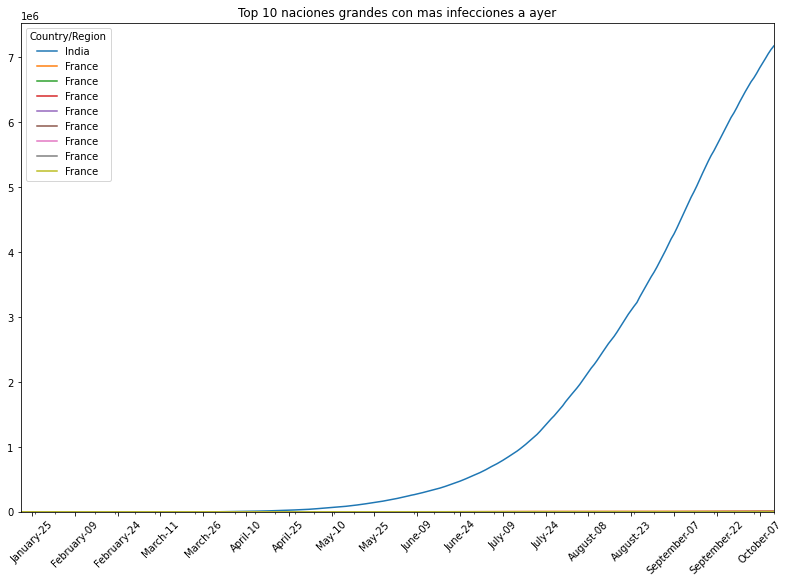

<module 'matplotlib.pyplot' from '/root/anaconda2/envs/jupyter/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [9]:
title="Top 10 naciones grandes con mas infecciones a ayer"
display(HTML(f"""<h1 id='{title}'>{title}</h1>"""))
df = get_data()

naciones_pintar = df_country.sort_values(by='infected last_day', ascending=False).head(10)['Country/Region'].values
df_country.sort_values(by='infected last_day', ascending=False).head(10)

pintar_grafico(df,naciones_pintar,title)



In [10]:
def pintar_grafico_daily(df, array_naciones_pintar ,title):
    df = df.T
    df = df.iloc[1:]
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    df = df.iloc[2:]
    df.index = pd.to_datetime(df.index)
    df = df[array_naciones_pintar]
    chart_df = df

    pd.plotting.register_matplotlib_converters()
    
    df_daily_increments = pd.DataFrame()
    for country in chart_df.columns:
        df_daily_increments[country] = chart_df[country].pct_change().rolling(window=7).mean()

    df_daily_increments    

    chart_df = df_daily_increments
    chart_df.tail(45).plot(legend=True,figsize=(13.5,9))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=45)

    ax = plt.gca()

    ax.set_title(title)
    ax.set_ylim(ymin=0)

    plt.show()

    chart_df.tail(30).style.format ({ c : "{:20,.2f}" for c in df.columns }).background_gradient(cmap='Wistia', )


    return chart_df


#pintar_grafico_daily(df,naciones_pintar,"Top 10 countries more cases, daily percentage change")
df_country

,Country/Region,infected last_day,PopTotal,Infected/Million
0,Afghanistan,71,38928341,1.823864
1,Albania,171,2877800,59.420391
2,Algeria,253,43851043,5.769532
3,Andorra,299,77265,3869.798745
4,Angola,122,32866267,3.712013
...,...,...,...,...
242,Uzbekistan,221,33469199,6.603086
243,Western Sahara,0,597330,0.000000
244,Yemen,0,29825967,0.000000
245,Zambia,91,18383956,4.949968


In [11]:
#pintar_grafico_daily(df,naciones_pintar,"Top 10 countries more cases, daily percentage change")